In [1]:
import time

import torch
import torch.nn as nn
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import numpy as np

from stabnode.node import FTerm, GTerm, set_global_seed, StabNODE
from data.hysteresis import simulate_steady_state
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
seed = 1234
set_global_seed(seed = seed)

# Simple hysteresis learning

In [3]:
lam_start = -1 
lam_end = 1

n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

In [4]:
x0=-1

simulate_time = (0.,100.)

x_increase = simulate_steady_state(lam_increase, x0, simulate_time)
x_decrease = simulate_steady_state(lam_decrease, x_increase[-1],simulate_time)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

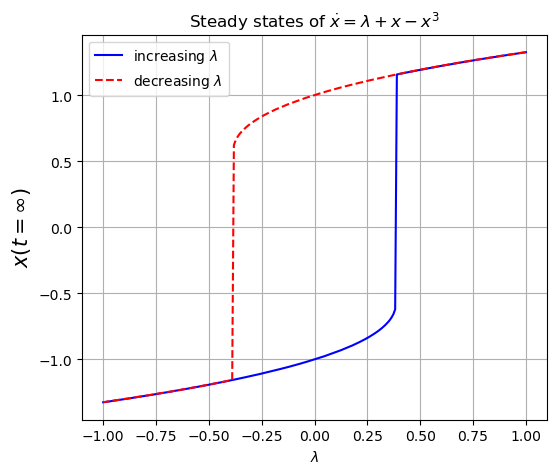

In [5]:
fig, ax = plt.subplots(1,1, figsize = (6,5))

ax.plot(lam_increase, x_increase, c='blue', label=r'increasing $\lambda$')
ax.plot(lam_decrease, x_decrease, c='red', linestyle="--", label=r'decreasing $\lambda$')
ax.grid(True)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$x(t = \infty)$",size = 15)
ax.set_title("Steady states of "+r"$\dot{x} = \lambda + x - x^3$")
ax.legend()
plt.show()

# Stabnode learning

In [6]:
X = np.hstack((x_increase, x_decrease))
lam = np.hstack((lam_increase, lam_decrease))
repeat = 2

for _ in range(repeat):
    X = np.hstack((X,X))
    lam = np.hstack((lam, lam))

tau = torch.arange(0,len(lam),device=device)
t = (tau+1)*simulate_time[-1]

In [7]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_scaled = scaler.fit_transform(X.reshape(-1,1))
X_scaled = torch.tensor(X_scaled,dtype=torch.float32, device=device)
scaler.data_max_, scaler.data_min_

(array([1.32447857]), array([-1.32447857]))

In [8]:
tau_train = tau[::5]
X_train = X_scaled[tau_train]
lam_train = lam[tau_train]

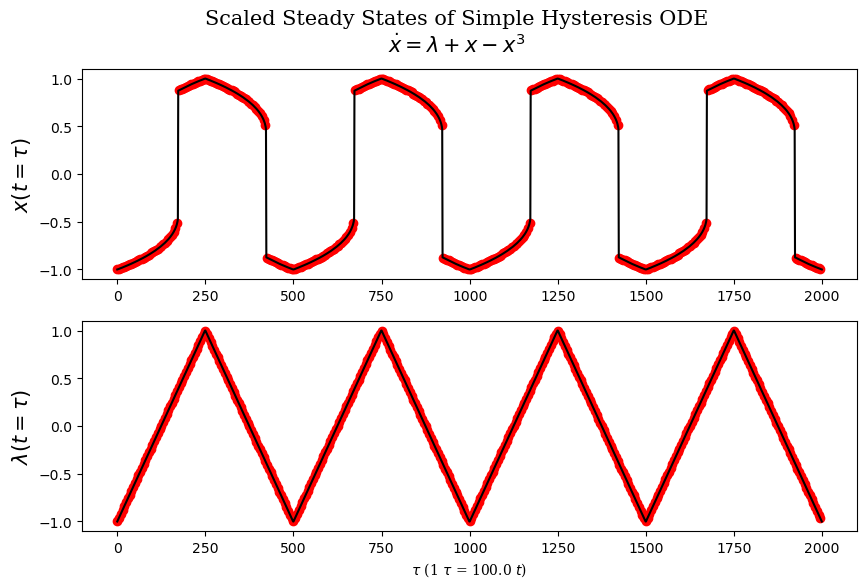

In [9]:
fig, ax = plt.subplots(2,1, figsize = (10,6))
color = 'black'

ax[0].plot(tau, X_scaled,c=color, label='True')
ax[0].scatter(tau_train, X_train,c='red', label='measurements')
ax[0].set_ylabel(r"$x(t = \tau)$",size=15, family='serif')

ax[1].plot(tau, lam,c=color)
ax[1].scatter(tau_train, lam_train,c='red')
ax[1].set_xlabel(fr"$\tau$ (1 $\tau$ = {simulate_time[-1]:.1f} $t$)",family='serif')
ax[1].set_ylabel(fr"$\lambda (t = \tau)$", family = 'serif', size=15)
plt.suptitle("Scaled Steady States of Simple Hysteresis ODE\n"+r"$\dot{x} = \lambda +x-x^3$",family='serif', size=15)
plt.show()

In [10]:
def lam_func(tau):
    idx = int(tau) % len(lam)
    return torch.tensor(lam[idx],dtype=torch.float32, device=device)

In [11]:
dim_in = X_train.shape[-1]
dim_out = X_train.shape[-1]
hidden_dim = 2

f = FTerm(dim_in, dim_out, hidden_dim )
g = GTerm(dim_in+1, dim_out, hidden_dim)

stab_node = StabNODE(f,g)
stab_node

StabNODE(
  (f): FTerm(
    (network): Sequential(
      (0): Linear(in_features=1, out_features=2, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2, out_features=1, bias=True)
      (3): Tanh()
    )
  )
  (g): GTerm(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2, out_features=1, bias=True)
      (3): Tanh()
    )
  )
)

In [12]:
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = 1e-2)

# early stopping criteria 
patience = ...
rtol = ...
print_every = 10

tau_span = tau_train.clone().detach().to(dtype=torch.float32, device=device)
x0 = X_train[0].reshape(-1, 1).clone().detach().to(dtype=torch.float32, device=device)

n_epochs = 250
losses = []
for epoch in tqdm(range(n_epochs)):
    t1 = time.time()
    opt.zero_grad()
    x_pred = odeint(lambda t, x: stab_node(t,x,lam_func), x0, tau_span, method='rk4')
    loss = loss_criteria(x_pred.squeeze(), X_train.squeeze())
    loss.backward()
    opt.step()
    t2 = time.time()
    losses.append(loss.item())
    if epoch <= 5 or epoch % print_every == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, time = {t2-t1:.4f} s.")
    

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 0: Loss = 1.8151, time = 0.6858 s.
Epoch 1: Loss = 1.5347, time = 0.7303 s.
Epoch 2: Loss = 1.3187, time = 0.8904 s.
Epoch 3: Loss = 1.1502, time = 0.7505 s.
Epoch 4: Loss = 1.0193, time = 0.7493 s.
Epoch 5: Loss = 0.9201, time = 0.7509 s.
Epoch 10: Loss = 0.8197, time = 0.7510 s.
Epoch 20: Loss = 0.7364, time = 0.7533 s.
Epoch 30: Loss = 0.5995, time = 0.7509 s.
Epoch 40: Loss = 0.4695, time = 0.7561 s.
Epoch 50: Loss = 0.3776, time = 0.7499 s.
Epoch 60: Loss = 0.3186, time = 0.8985 s.
Epoch 70: Loss = 0.2818, time = 0.7525 s.
Epoch 80: Loss = 0.2607, time = 0.7534 s.
Epoch 90: Loss = 0.2494, time = 0.8935 s.
Epoch 100: Loss = 0.2435, time = 0.7530 s.
Epoch 110: Loss = 0.2404, time = 0.7511 s.
Epoch 120: Loss = 0.2387, time = 0.7520 s.
Epoch 130: Loss = 0.2378, time = 0.7531 s.
Epoch 140: Loss = 0.2372, time = 0.7546 s.
Epoch 150: Loss = 0.2369, time = 0.7552 s.
Epoch 160: Loss = 0.2367, time = 0.7546 s.
Epoch 170: Loss = 0.2366, time = 0.7568 s.
Epoch 180: Loss = 0.2365, time =

In [13]:
# losses

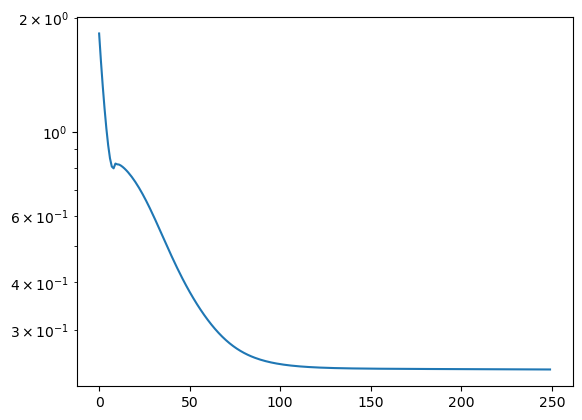

In [14]:
plt.plot(losses)
plt.yscale('log')
plt.show()

In [15]:
losses = np.array(losses)

In [16]:
losses[-10:]

array([0.23582825, 0.23581797, 0.2358077 , 0.23579745, 0.23578717,
       0.23577684, 0.23576656, 0.23575625, 0.23574597, 0.23573564])

In [17]:
loss_diff = losses[1:] - losses[:-1]

In [18]:
loss_diff[-50:].min()

-1.0326504707336426e-05

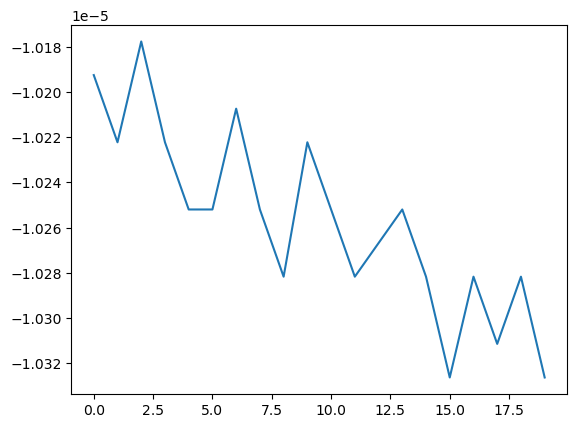

In [19]:
plt.plot(loss_diff[-20:])

# g and f outputs

In [20]:
def g_true(x,lam):
    return (1/x)*((lam / x)  + 1)

def f_true(x):
    return -x**2

In [21]:
g.eval()
f.eval()


g_true_out = []
g_pred_out = []

f_true_out = []
f_pred_out = []

for tau_i in tau:

    lam_i = lam_func(tau_i).reshape(-1,1)
    xi = X_scaled[tau_i].reshape(-1,1)
    xi_unscaled = X[tau_i].reshape(-1,1)

    g_true_out.append(g_true(xi_unscaled,lam_i.numpy()))
    f_true_out.append(f_true(xi_unscaled))

    with torch.no_grad():
        g_pred_out.append(g(xi,lam_i).detach().cpu().numpy())
        f_pred_out.append(f(xi).detach().cpu().numpy())

g_true_out = np.array(g_true_out).reshape(-1)
g_pred_out = np.array(g_pred_out).reshape(-1)

f_true_out = np.array(f_true_out).reshape(-1)
f_pred_out = np.array(f_pred_out).reshape(-1)
    

In [22]:
finite_idx = np.isfinite(g_true_out)
np.count_nonzero(~finite_idx)

0

In [23]:
g_true_scaled = scaler.transform(g_true_out[finite_idx].reshape(-1,1)).reshape(-1)

In [35]:
g_pred_out[0], x0

(-0.86232865, tensor([[-0.9999]]))

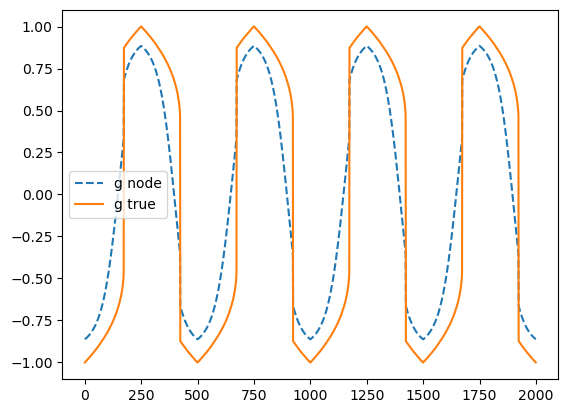

In [24]:
plt.plot(g_pred_out, linestyle='--', label='g node')
plt.plot(g_true_scaled, label='g true')
# plt.plot(X_scaled, label='raw data')
plt.legend()
plt.show()

In [25]:
x0, tau_train[0]

(tensor([[-0.9999]]), tensor(0))

In [26]:
X_scaled[:10]

tensor([[-0.9999],
        [-0.9990],
        [-0.9978],
        [-0.9960],
        [-0.9951],
        [-0.9931],
        [-0.9920],
        [-0.9902],
        [-0.9889],
        [-0.9874]])

In [27]:
scaler.data_max_

array([1.32447857])

In [28]:
g_true_out.max()

1.3251213933159323

In [29]:
f_true_scaled = scaler.transform(f_true_out.reshape(-1,1)).reshape(-1)

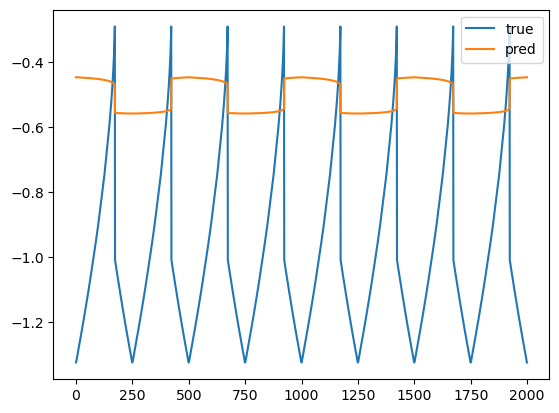

In [30]:
plt.plot(f_true_scaled,label='true')
plt.plot(f_pred_out, label='pred')
plt.legend()
plt.show()

In [31]:
X_train[0].numpy()

array([-0.9999028], dtype=float32)

In [32]:
X_scaled[0]

tensor([-0.9999])